# Nematic Transition for Heisenberg Model

We will determine the self-consistent bond equation $K_{\mathbf{q}}^{\mathrm{eff}}=K_{\mathbf{q}}+\int_{\mathbf{p}}\frac{T^2D_\mathbf{p}}{K_{\mathbf{p+q}}^{\mathrm{eff}}}$ with $D_{\mathbf{p}}=\frac{2}{NT^2}\left(\int_{\mathbf{k}}\frac{1}{K_{\mathbf{k}}^{\mathrm{eff}}}\frac{1}{K_{\mathbf{k+p}}^{\mathrm{eff}}}\right)^{-1}$, and check for spontaneous symmetry breaking of $C_{4V}$.

Define variables:

In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

#Set values for size, spin and J.
m = 50 #size of 2d-lattice (m x m)
NS = 3.0 #number of spin components
J1 = 1.0
J2 = 0.0
J3 = 0.5

DeltaList = np.linspace(2*10**(-5),10**(-1),300) #list of Delta (changes temp.)
maxNsteps = 400 #max iterations each step
convCrit = 10**(-11) #decides when sigma has converged
checkNSteps = 10 #check for convergence every n-step

fileName = 'sigmaResult.dat' #name on the file we save results to


#setting constants
da = 0.1 #adds symmetry breaking term to K
dq = 2.0*np.pi/float(m) #constant, used later
nTemp = len(DeltaList) #number of temp
nStepsNow = 0
stepsInN = 0

Setting up functions and tables:

In [247]:
#making JFTtab:
def J (qx, qy):
    return (-J1*(np.cos(qx) + np.cos(qy))+ 2*J2*np.cos(qx)
            *np.cos(qy) + J3*(np.cos(2.0*qx) + np.cos(2.0*qy)))

JFT=np.fromfunction(lambda qx,qy: J(dq*qx-np.pi,dq*qy-np.pi), (m,m)) #(qx vertical, qy horizontal)


#making dK tab for symmetry breaking
def dKfunc (qx,qy):
    return np.cos(qx)*np.sin(np.sqrt(2.0)*qy)+np.cos(np.sqrt(3.0)*(qx+0.4*qy))

dKtab = np.fromfunction(lambda qx,qy: dKfunc(dq*qx-np.pi,dq*qy-np.pi), (m,m)) 


#making tables to check for symmetry breaking along axis and diagonals
def funcAxis(qx,qy):
    return np.cos(qx)-np.cos(qy)
def funcDia(qx,qy):
    return np.cos((qx+qy))-np.cos((qx-qy))

symTabAxis = np.fromfunction(lambda qx,qy: funcAxis(dq*qx-np.pi,dq*qy-np.pi), (m,m)).flatten()
symTabDia = np.fromfunction(lambda qx,qy: funcDia(dq*qx-np.pi,dq*qy-np.pi), (m,m)).flatten()


#calculates temp, once K and self-energy is known
def Temp(K1):
    return ((2.0/NS)*m*m/(np.sum(np.reciprocal(K1))))

Making tables for saving results:

In [248]:
sigma = np.zeros((int(maxNsteps/checkNSteps),3)) # saved as ['Delta', 'sigmaAxis', 'sigmaDia']
sigmaTemp = pd.DataFrame(np.zeros((nTemp,4)), \
                         columns=['Delta','Temperature', 'sigmaAxis', 'sigmaDia']) #results

Iterating through values of Delta

In [249]:
for temp in range(0,nTemp):
    Delta=DeltaList[temp] #set Delta
    
    K0 = JFT - np.min(JFT) + Delta #making sure K0 is positive
    K1 = K0 + da*dKtab -np.min(K0 + da*dKtab)+Delta #adding symmetry breaking term to K0
    
    sigma[0] = np.array([[Delta,np.dot(symTabAxis,K1.flatten())/(m*m),
          np.dot(symTabDia,K1.flatten())/(m*m)]]) #calculating value of sigma

    for i in range(1,maxNsteps): #iterating while checking for convergence
        K1inv = np.reciprocal(K1)
        
        #calculating D using convolution
        invK1Real = np.fft.ifft2(K1inv)
        invK1RealConj = np.conj(invK1Real)
        invK1RealMult = np.multiply(invK1Real, invK1RealConj)
        invK1Conv = np.real(np.fft.fft2(invK1RealMult))#get D1 real,complex part very small.
        D1 = (2.0/NS)*np.reciprocal(invK1Conv) 

        #calculating self-energy using convolution
        D1Real = np.fft.ifft2(D1)
        D1K1RealMult =  np.multiply(D1Real, invK1RealConj)
        D1K1Conv = np.real(np.fft.fft2(D1K1RealMult)) #get real part, complex part very small. 
      
        #add self-energy
        K10 = K0+D1K1Conv #last term is the self-energy
        K1 = K10 - np.min(K10)+Delta #redefine K1

        #checking for convergence and calculating sigma
        if(i%checkNSteps == 0):
            nStepsNow = int(i/checkNSteps)
            #calcualting sigma:
            sigma[nStepsNow] = np.array([Delta,np.dot(symTabAxis,K1.flatten())/(m*m),
                  np.dot(symTabDia,K1.flatten())/(m*m)])
            #checking for convergence in sigma
            if(abs(sigma[nStepsNow][1] -sigma[nStepsNow-1][1])<convCrit \
                and abs(sigma[nStepsNow][2] -sigma[nStepsNow-1][2])<convCrit):
                stepsInN = nStepsNow
                break
            elif(i > maxNsteps-checkNSteps-1):
                print('sigma did not converge')
                stepsInN = nStepsNow
                break
       
    #calcualting temp from K1 and saving value.
    sigmaTemp.iloc[temp] = np.array([Delta,Temp(K1),sigma[stepsInN][1],\
                                  sigma[stepsInN][2]])


sigma did not converge
sigma did not converge
sigma did not converge
sigma did not converge
sigma did not converge
sigma did not converge
sigma did not converge
sigma did not converge
sigma did not converge
sigma did not converge


Saving results to file

In [250]:
sigmaTemp.to_csv(fileName, index=False)

Plotting for sigma, temp and Delta:

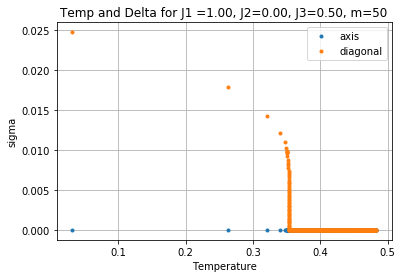

In [251]:
fig1 = plt.figure()
plt.plot(sigmaTemp['Temperature'],sigmaTemp['sigmaAxis'],'.',label = 'axis')
plt.plot(sigmaTemp['Temperature'],sigmaTemp['sigmaDia'],'.',label = 'diagonal')
plt.title('Temp and Delta for J1 =%.2f, J2=%.2f, J3=%.2f, m=%i'%(J1,J2,J3,m))
plt.xlabel('Temperature')
plt.ylabel('sigma')
plt.legend()
plt.grid()
plt.show()

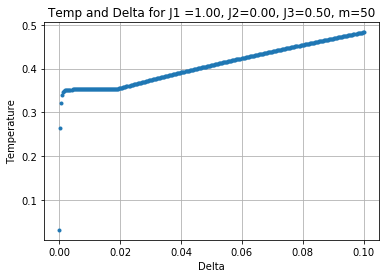

In [252]:
fig2 = plt.figure()
plt.plot(sigmaTemp['Delta'],sigmaTemp['Temperature'],'.')
plt.title('Temp and Delta for J1 =%.2f, J2=%.2f, J3=%.2f, m=%i'%(J1,J2,J3,m))
plt.xlabel('Delta')
plt.ylabel('Temperature')
plt.grid()
plt.show()

Plotting K0, K1, D (taking values from last ittereation)

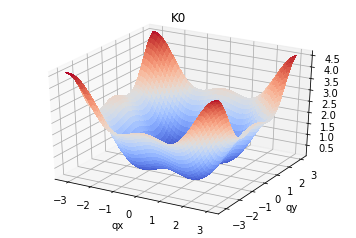

In [253]:
#plotting K0
figK0 = plt.figure()

XY=np.fromfunction(lambda qy,qx: qx*dq-np.pi, (1,m))
Y, X = np.meshgrid(XY, XY)
Z = K0
ax = figK0.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z,cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('qx')
ax.set_ylabel('qy')
plt.title('K0')
plt.show()

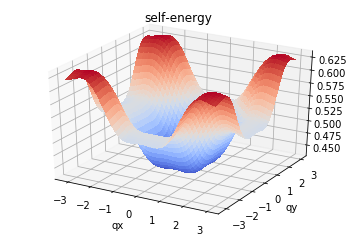

In [254]:
#plotting last self-energy
figSelfEnergy = plt.figure()

XY=np.fromfunction(lambda qy,qx: qx*dq-np.pi, (1,m))
Y, X = np.meshgrid(XY, XY)
index = int(m/2)+1
Z = D1K1Conv

ax = figSelfEnergy.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z,cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('qx')
ax.set_ylabel('qy')
plt.title('self-energy')
plt.show()

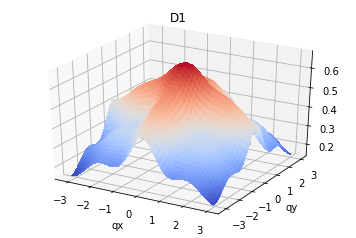

In [255]:
#plotting last self-energy
D1Fig = plt.figure()

XY=np.fromfunction(lambda qy,qx: qx*dq-np.pi, (1,m))
Y, X = np.meshgrid(XY, XY)
index = int(m/2)+1
Z = D1

ax = D1Fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z,cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('qx')
ax.set_ylabel('qy')
plt.title('D1')
plt.show()